In [1]:
from scgenome.tantalus import get_data
from scgenome.qc import qc_cn
from IPython.display import display

hmmcopy_tickets = [
#     'SC-1935',
    'SC-1936',
#     'SC-1937',
]

sample_ids = [
#     'SA922',
    'SA921', 
#     'SA1090',
]

data = get_data(hmmcopy_tickets, sample_ids, cached=True)
cn_data = data[0]
segs_data = data[1]
metrics_data = data[2]
align_metrics_data = data[3]

print("cn_data.head()")
display(cn_data.head())

#cn = qc_cn(metrics_data, cn_data)
#print("cn.head()")
#display(cn.head())

/Users/massoudmaher/Documents/Code/scgenome/scgenome/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
/Users/massoudmaher/Documents/Code/scgenome/scgenome/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].cat.set_categories(col_categories[col])
2019-09-07 14:27:28,713 - INFO - cdfa9ee0-a8b7-4060-aeb8-f02e0bf6aabe - TokenRequest:Getting token with client credentials.
2019-09-07 14:27:29,053 - INFO - cdfa9ee0-a8b7-4060-aeb8-f02e0bf6aabe - OAuth2Client:Get Token Server r

cn_data.head()


,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id
0,1,1,500000,0,-1.000000,NaN,2,SA921-A90554A-R12-C09,SA921,A90554A
1,1,500001,1000000,41,-1.000000,NaN,2,SA921-A90554A-R12-C09,SA921,A90554A
2,1,1000001,1500000,6,0.598332,1.754408,2,SA921-A90554A-R12-C09,SA921,A90554A
3,1,1500001,2000000,10,0.539498,1.873090,2,SA921-A90554A-R12-C09,SA921,A90554A
4,1,2000001,2500000,9,0.594508,2.515035,2,SA921-A90554A-R12-C09,SA921,A90554A


In [2]:
# Subset small amount of cells
n_cell = 10

keep_cells = cn_data["cell_id"].value_counts().index[0:n_cell]
sub_cn_data = cn_data[cn_data["cell_id"].isin(keep_cells)]

In [3]:
# BHC them!
from scgenome.cncluster import bayesian_cluster

linkage, clusters, cell_ids = bayesian_cluster(sub_cn_data, n_states = sub_cn_data["state"].max())

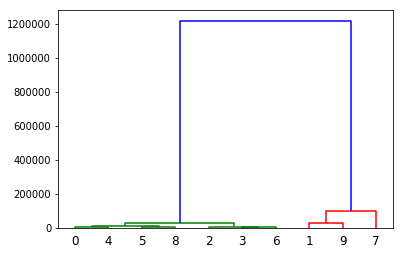

In [4]:
from scipy.cluster.hierarchy import dendrogram
from scgenome.simulation import get_plot_data

plinkage, plot_data = get_plot_data(linkage)
f = dendrogram(plot_data)

In [5]:
hmmcopy_tickets = ['SC-1937']
sample_ids = ['SA1090']

xdata = get_data(hmmcopy_tickets, sample_ids, cached=True)
xcn_data = xdata[0]
xsegs_data = xdata[1]
xmetrics_data = xdata[2]
xalign_metrics_data = xdata[3]

print("cn_data.head()")
display(xcn_data.head())

/Users/massoudmaher/Documents/Code/scgenome/scgenome/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
/Users/massoudmaher/Documents/Code/scgenome/scgenome/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].cat.set_categories(col_categories[col])
2019-09-07 14:28:39,389 - INFO - 2acd6420-8b86-47f7-a868-186119d6de86 - TokenRequest:Getting token with client credentials.
2019-09-07 14:28:39,547 - INFO - 2acd6420-8b86-47f7-a868-186119d6de86 - OAuth2Client:Get Token Server r

cn_data.head()


,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id
0,1,1,500000,2,-1.000000,NaN,2,SA1090-A96213A-R34-C64,SA1090,A96213A
1,1,500001,1000000,42,-1.000000,NaN,2,SA1090-A96213A-R34-C64,SA1090,A96213A
2,1,1000001,1500000,43,0.598332,3.017390,2,SA1090-A96213A-R34-C64,SA1090,A96213A
3,1,1500001,2000000,42,0.539498,1.936414,2,SA1090-A96213A-R34-C64,SA1090,A96213A
4,1,2000001,2500000,36,0.594508,2.439622,2,SA1090-A96213A-R34-C64,SA1090,A96213A


In [6]:
# Subset small amount of cells
xkeep_cells = xcn_data["cell_id"].value_counts().index[0:n_cell]
xsub_cn_data = xcn_data[xcn_data["cell_id"].isin(xkeep_cells)]

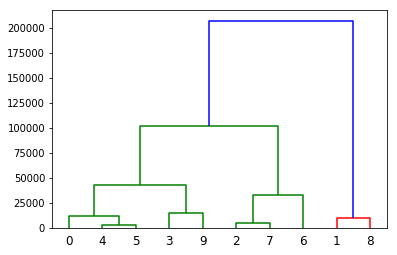

In [7]:
# BHC them!
xlinkage, xclusters, xcell_ids = bayesian_cluster(xsub_cn_data, n_states = xsub_cn_data["state"].max())

xplinkage, xplot_data = get_plot_data(xlinkage)
f = dendrogram(xplot_data)

In [8]:
# Combine two datasets and see if we can seperate 
sub_cn_data["cell_id"] = "cl1_" + sub_cn_data["cell_id"].astype("str")
xsub_cn_data["cell_id"] = "cl2_" + xsub_cn_data["cell_id"].astype("str")

bi_cn_data = sub_cn_data.append(xsub_cn_data)
bilinkage, biclusters, bicell_ids = bayesian_cluster(bi_cn_data, n_states = bi_cn_data["state"].max())

biplinkage, biplot_data = get_plot_data(bilinkage)
#f = dendrogram(biplot_data, labels = bicell_ids.str[2])

/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
from scgenome import utils

In [20]:
bi_cn_mat, bi_cn_meas, bi_cn_ids = utils.cn_data_to_mat_data_ids(bi_cn_data, data_id="state")
#def cn_data_to_mat_data_ids(cn_data, data_id=CN_DATA_ID, cell_id=CELL_ID,
#                            index_ids=INDEX_IDS, value_ids=VALUE_IDS):
y_labels = bi_cn_ids.str[2].astype(int) - 1

In [24]:
nbiplot_data = biplot_data.copy()
nbiplot_data[:,2] = np.log(nbiplot_data[:,2])

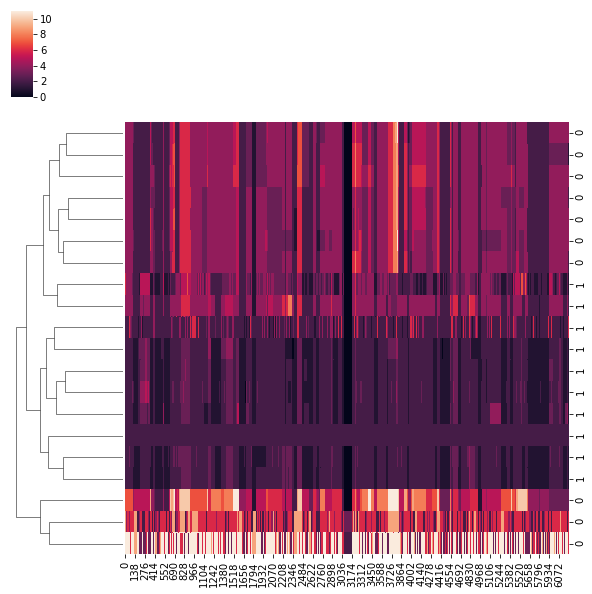

In [25]:
g = sns.clustermap(bi_cn_meas, col_cluster=False, row_linkage=nbiplot_data, yticklabels = y_labels)

[[0.         1.         2.42450038 2.        ]
 [2.         3.         4.31653738 2.        ]
 [4.         5.         5.67636475 4.        ]]
[[ 0.45805575  1.52251688  1.52578318  1.26362246  0.30357277  1.99042258
   0.63266034  1.02814346  1.32183935  2.07330383]
 [ 1.06422456  0.93863039  0.71897957  1.08236339  1.43254052  0.47486307
   0.16667024  1.75579593  1.04051799  1.77531776]
 [-0.7447503  -0.69542534 -0.7851022   0.40066584  0.24768322 -0.55408079
  -0.77458851  0.99224698 -1.75175661 -1.66317469]
 [ 0.45362093  0.07843531 -2.09725954 -0.63732444  0.39652234 -0.41194575
  -2.55298113 -1.57232396 -3.51581639 -0.71217859]]


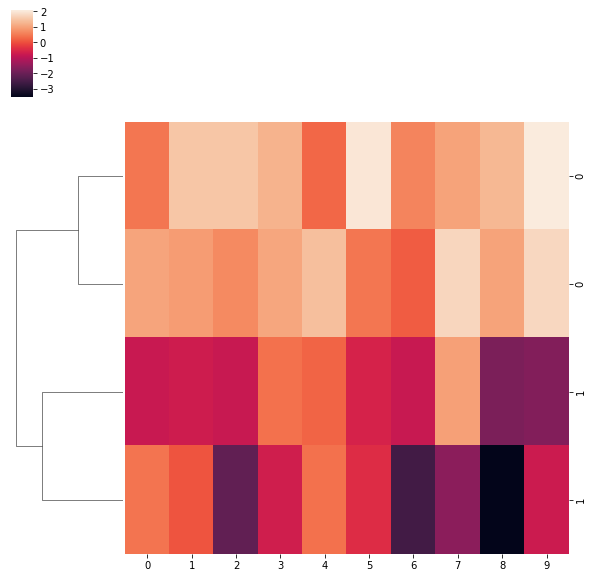

In [13]:
import seaborn as sns
import numpy as np
import scipy

cl1 = np.random.normal(loc=1,size=(2,10))
cl2 = np.random.normal(loc=-1,size=(2,10))
dat = np.concatenate([cl1,cl2], axis=0)
y_labels = ["0","0","1","1"]

linkage = scipy.cluster.hierarchy.linkage(dat)
print(linkage)

print(dat)
g = sns.clustermap(dat, col_cluster=False, row_linkage=linkage, yticklabels = y_labels)